# Network creation & Analysis

## Data Preparation

### <span style="color:teal">Creating nodes and edges for the network</span>

From the csv files created in the previous notebook(check 02.ipynb), we will be creating a node list and edge list <br>to use as input for creating a netowork representation using netowrkX.

In [15]:
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors

### <span style="color:teal">Helper Functions</span>

In [112]:
def remove_nan_empty_rows(dataframe):
    dataframe.replace('', np.nan, inplace=True)
    dataframe.dropna(inplace=True)
    dataframe.dropna(how='all', inplace=True)
    dataframe.dropna(subset=dataframe.columns.values.tolist(), how='all', inplace=True)
    dataframe.dropna(subset=dataframe.columns.values.tolist(), how='any', inplace=True)
    dataframe.replace(np.nan, '', inplace=True)
    
    return dataframe

#removing self-loops from the edge list dataframe
def remove_selfloop(df, column1, column2):
    # Drop rows where the values in column1 and column2 are equal
    df = df[df[column1] != df[column2]]

    # Reset the index of the dataframe
    df = df.reset_index(drop=True)

    return df

#adding nodes from node_list
def add_nodes_from_dataframe(df):
    # Create an empty graph
    G = nx.DiGraph()

    # Iterate over the rows of the DataFrame
    for index, row in df.iterrows():
        # Extract the node name from the row
        node_name = row['video ID']   #this could be the vide ID in our case

        # Extract the attributes from the row (excluding the 'Node' column)
        attributes = row.drop('video ID').to_dict()   

        # Add the node with its attributes to the graph
        G.add_node(node_name, **attributes)

    return G

#adding edges from edge_list
def edges_from_df(df,graph):
    
    g_nodes = set(graph.nodes())

    set2 = set(list(graph.nodes))
    for idx,row in tqdm(df.iterrows()):
        source = row[0]
        target = row[1]
        #print(source,target) this works just fine
        set1 = {source,target}
        is_proper_subset = set1.issubset(set2) and set1 != set2
        if is_proper_subset:
            graph.add_edges_from([(source,target)])
        else:
            continue
    return graph

# writing a function for graph creation
def create_Digraph(df_nlist,df_elist):
    #step 1 - declare the graph variable
    G = nx.DiGraph()
    
    #step 2 - add nodes from the nlist
    G = add_nodes_from_dataframe(df_nlist)
    
    #step 3 - check for orpahn nodes
    G = edges_from_df(df_elist,G)
    
    #step 4 - remove all orpahn nodes
    orphan_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
    print(len(orphan_nodes),' orphan nodes removed')
    
    return G

# function for making a dataframe of attributes of a list of nodes
def get_node_attributes(graph, nodes):
    # nodes should be a list of node IDs
    # Create an empty DataFrame to store node attributes
    node_attributes = pd.DataFrame(columns=graph.nodes[nodes[0]])

    # Iterate over the nodes and collect their attributes
    for node in nodes:
        attributes = graph.nodes[node]
        node_attributes = node_attributes.append(attributes, ignore_index=True)

    return node_attributes

def find_common_nodes(graph1, graph2):
    """
    Find the set of common nodes between two graphs.

    Parameters:
        graph1 (networkx.Graph): The first graph.
        graph2 (networkx.Graph): The second graph.

    Returns:
        set: The set of common nodes between the two graphs.
    """
    nodes1 = set(graph1.nodes())
    nodes2 = set(graph2.nodes())
    common_nodes = nodes1.intersection(nodes2)
    return common_nodes

def calculate_eccentricity(graph):
    eccentricities = {}

    # Calculate eccentricity for each connected component
    for component in nx.strongly_connected_components(graph):
        component_graph = graph.subgraph(component)
        component_eccentricities = nx.eccentricity(component_graph)
        eccentricities.update(component_eccentricities)

    # Set infinite eccentricity for nodes not in any component
    for node in graph.nodes():
        if node not in eccentricities:
            eccentricities[node] = float('inf')

    return eccentricities

# function to export .gexf file for gephi
def export(graph_var,name):
    if '.gexf.gz' in name: 
        nx.write_gexf(graph_var,name)
    else:
        print('enter a name with file type as `.gexf.gz`')

### <span style="color:teal">Data Import and Preparation</span>

Now we importe the network data from the CSVs we created earlier.

In [102]:
# Importing the edge lists

eList1 = pd.read_csv("eList1.csv",delimiter=',',low_memory=False)
eList2 = pd.read_csv("eList2.csv",delimiter=',',low_memory=False)
len(eList1)  # length after import -> 15,41,415

1541415

In [18]:
# now we process the edge list dataframes so that they are ready to used for the graph creator function

# removing nan/ NaN and other such values
eList1 = remove_nan_empty_rows(eList1)
# removing self-loops 
eList1 = remove_selfloop(eList1, '0', '1')
# removing duplicates
eList1.drop_duplicates(inplace=True)
len(eList1) # length after cleaning -> 14,70,158

1470158

In [19]:
#performing cleaninging on the second edge list 
len(eList2) # length after import -> 21,90,420

2190420

In [103]:
# removing nan/ NaN and other such values
eList2 = remove_nan_empty_rows(eList2)
# removing self-loops 
eList2 = remove_selfloop(eList2, '0', '1')
# removing duplicates
eList2.drop_duplicates(inplace=True)
len(eList2) # length after cleaning -> 15,33,099

1533099

#### Design decisions for creating the network graphs

Certain decisions were made after much trail and error with the data, the following steps are a result of those trails.

For example, we will be choosing only half the the edges from the edge lists to keep the network graph managable for computation at later stages. The choice of selecting which nodes to keep and which to drop is completly aribitrary as the dataframe is not sorted in any sense except maybe time they were crawled through by the web scrapper.

Similar approach is taken for the node list.

In [21]:
# Select half of the dataframe for 2007 edge list
sub7 = eList1.head(int(len(eList1)/2))
sub8 = eList2.head(int(len(eList2)/2))

# Importing the node lists with the attribute data
NL7 = pd.read_csv("S_data07.csv",delimiter=',',low_memory=False)
NL8 = pd.read_csv("S_data08.csv",delimiter=',',low_memory=False)

In [22]:
len(NL7) # length after import -> 3,84,474

384474

In [23]:
# cleaning the node list
NL7 = remove_nan_empty_rows(NL7)
# selecting half the node list
NL7_1 = NL7.head(int(len(NL7)/2))
NL7_2 = NL7.tail(int(len(NL7)/2))

# cleaning the node list
NL8 = remove_nan_empty_rows(NL8)
# selecting half the node list
NL8_1 = NL8.head(int(len(NL8)/2))
NL8_2 = NL8.tail(int(len(NL8)/2))

## Making the graph 

Making the graph for the april 2007 now, we will be storing it in the variable called `g1`

In [24]:
g1 = nx.DiGraph()
g1 = add_nodes_from_dataframe(NL7_1)
g1 = edges_from_df(eList1,g1)

# check the node and edge count
print("Number of nodes:", g1.number_of_nodes())  # 1,90,206
print("Number of edges:", g1.number_of_edges())  # 1,90,877

1470158it [00:33, 43883.23it/s]

Number of nodes: 190206
Number of edges: 190877


In [25]:
# now we remove the orphan nodes from this graph of 2007
# 1 - Find orphan nodes
orphan_nodes = [node for node in g1.nodes() if g1.in_degree(node) == 0 and g1.out_degree(node) == 0]
print(len(orphan_nodes))
# 2 - remove orphan nodes
g1.remove_nodes_from(orphan_nodes)

81963


In [26]:
# check the node and edge count
print("Number of nodes:", g1.number_of_nodes())  # 1,08,243
print("Number of edges:", g1.number_of_edges())  # 1,90,877

Number of nodes: 108243
Number of edges: 190877


<hr>
Making the graph for the april 2008 now, we will be storing it in the variable called `g2`

In [27]:
g2 = nx.DiGraph()
g2 = add_nodes_from_dataframe(NL8_1)
g2 = edges_from_df(eList2,g2)

# check the node and edge count
print("Number of nodes:", g2.number_of_nodes())  # 2,48,350
print("Number of edges:", g2.number_of_edges())  # 2,66,613

1533099it [00:34, 43858.84it/s]

Number of nodes: 248350
Number of edges: 266613


In [32]:
# now we remove the orphan nodes from this graph
# 1 - Find orphan nodes
orphan_nodes = [node for node in g2.nodes() if g2.in_degree(node) == 0 and g2.out_degree(node) == 0]
print(len(orphan_nodes))
# 2 - remove orphan nodes
g2.remove_nodes_from(orphan_nodes)

# check the node and edge count after orphan removal
print("Number of nodes:", g2.number_of_nodes())  # 1,45,489
print("Number of edges:", g2.number_of_edges())  # 2,66,613

0
Number of nodes: 145489
Number of edges: 266613


We also make a subgraph of the biggest weekly connected component of `g1` and another subgraph of the biggest strongly connected componenet from `g2`

In [52]:
# Find the giant component
giant_component = max(nx.weakly_connected_components(g1), key=len)

# Create the subgraph from the giant component
giant_subgraph = g1.subgraph(giant_component)

giant_component8 = max(nx.strongly_connected_components(g2), key=len)
giant_subgraph8 = g2.subgraph(giant_component8)

## Doing some basic analysis of the network

We will be conducting some basic measurements to understand the nature of the network before going for specific analysis. First we take the network graph for the year 2007 - that is `g1` and later `g2`

### <span style="color:teal">Performing basic analysis of the network's structure</span>

In [33]:
def diameter_directed(G):
    # Get strongly connected components
    components = nx.strongly_connected_components(G)

    # Calculate the maximum diameter among components
    max_diameter = 0
    for component in components:
        component_graph = G.subgraph(component)
        diameter = nx.diameter(component_graph)
        if diameter > max_diameter:
            max_diameter = diameter

    print("Network Diameter:", max_diameter)
    
def basic_measures(g):

    print("Density:", nx.density(g))
    diameter_directed(g)
    print("Reciprocity:", nx.reciprocity(g))
    print("Average in-degree:", sum(dict(g.in_degree()).values()) / g.number_of_nodes())
    print("Average out-degree:", sum(dict(g.out_degree()).values()) / g.number_of_nodes())
    print("Assortativity coefficient:", nx.degree_assortativity_coefficient(g))
    print("Transitivity:", nx.transitivity(g))
    print("Number of strongly connected components:", nx.number_strongly_connected_components(g))  #output - 2,79,984
    print("Number of weakly connected components:", nx.number_weakly_connected_components(g)) # output - 23,818
    print(nx.is_directed_acyclic_graph(g))

In [34]:
basic_measures(g1)

Density: 1.629138368411498e-05
Network Diameter: 20
Reciprocity: 0.2669886890510643
Average in-degree: 1.7634119527359737
Average out-degree: 1.7634119527359737
Assortativity coefficient: 0.30243865280017784
Transitivity: 0.47550274445530777
Number of strongly connected components: 89797
Number of weakly connected components: 13786
False


In [35]:
basic_measures(g2)

Density: 1.2595748751694415e-05
Network Diameter: 43
Reciprocity: 0.373642695592488
Average in-degree: 1.8325302943865172
Average out-degree: 1.8325302943865172
Assortativity coefficient: 0.17740002030236565
Transitivity: 0.25977746433781446
Number of strongly connected components: 101261
Number of weakly connected components: 10175
False


In [63]:
#### counting Number of strongly connected components in each graph
s_components = nx.strongly_connected_components(g1)
s_components2 = nx.strongly_connected_components(g2)

s = 0
for item in s_components:
    if len(item)> s:
        s = len(item)

print('No. of strongly connected components in 2007 - ',s)

s = 0
for item in s_components2:
    if len(item)> s:
        s = len(item)
print('No. of strongly connected components in 2007 - ',s)

No. of strongly connected components in 2007 -  219
No. of strongly connected components in 2007 -  1635


### <span style="color:teal">Assortivity in the networks</span>

In [37]:
print(nx.attribute_assortativity_coefficient(g1, "category"))  #output -> 0.5997368829782115
print(nx.attribute_assortativity_coefficient(g1, "age"))   #output -> 0.15578536383068303
print(nx.attribute_assortativity_coefficient(g1, "rate"))      #output -> 0.09425041007829454
print(nx.attribute_assortativity_coefficient(g1, "ratings"))   #output -> 0.07666366912630876
print(nx.attribute_assortativity_coefficient(g1, "comments"))  #output -> 0.0905428121827432
#print(nx.attribute_assortativity_coefficient(g1, "views"))     #output -> 0.0015915504082061908

0.5997368829782115
0.15578536383068303
0.09425041007829454
0.07666366912630876
0.0905428121827432


In [38]:
print(nx.attribute_assortativity_coefficient(g2, "category"))  #output -> 0.5276899000024023
print(nx.attribute_assortativity_coefficient(g2, "age"))   #output -> 0.15578536383068303
print(nx.attribute_assortativity_coefficient(g2, "rate"))      #output -> 0.05164874282976598
print(nx.attribute_assortativity_coefficient(g2, "ratings"))   #output -> 0.02717917361672679
print(nx.attribute_assortativity_coefficient(g2, "comments"))  #output -> 0.031683894216178794
#print(nx.attribute_assortativity_coefficient(g2, "views"))    #output -> UNKNOWS DUE TO RUN TIME

0.5276899000024025
0.1415352775592971
0.05164874282976598
0.02717917361672679
0.031683894216178794


### <span style="color:teal">Shortest Path in the network's biggest component</span>

In [41]:
# Print the number of nodes and edges in the subgraph
print("Number of nodes in the subgraph:", giant_subgraph.number_of_nodes())
print("Number of edges in the subgraph:", giant_subgraph.number_of_edges())

#print("average shortest path length - ",nx.average_shortest_path_length(giant_subgraph)) # output -> 0.0024737974990778314

Number of nodes in the subgraph: 40389
Number of edges in the subgraph: 85520


### <span style="color:teal">Small world comparison</span>

In [42]:
def ASP(G):
  components = nx.connected_components(G)
  average_shortest_path = 0
  for component in tqdm(components):
      component_graph = G.subgraph(component)
      component_shortest_path = nx.average_shortest_path_length(component_graph)
      average_shortest_path += component_shortest_path * len(component)
  total_nodes = G.number_of_nodes()
  average_shortest_path /= total_nodes
  return average_shortest_path

31it [00:08,  3.53it/s]
1it [00:09,  9.72s/it]

Watts-Strogatz (Small-World) Network:
Clustering Coefficient: 0.1859327217125379
Average Shortest Path Length: 6.719703996496468

Random Network:
Clustering Coefficient: 0.0025265322513028927
Average Shortest Path Length: 5.373668275793697

Regular Network:
Clustering Coefficient: 0.257430199309617
Average Shortest Path Length: 8.611279425360927


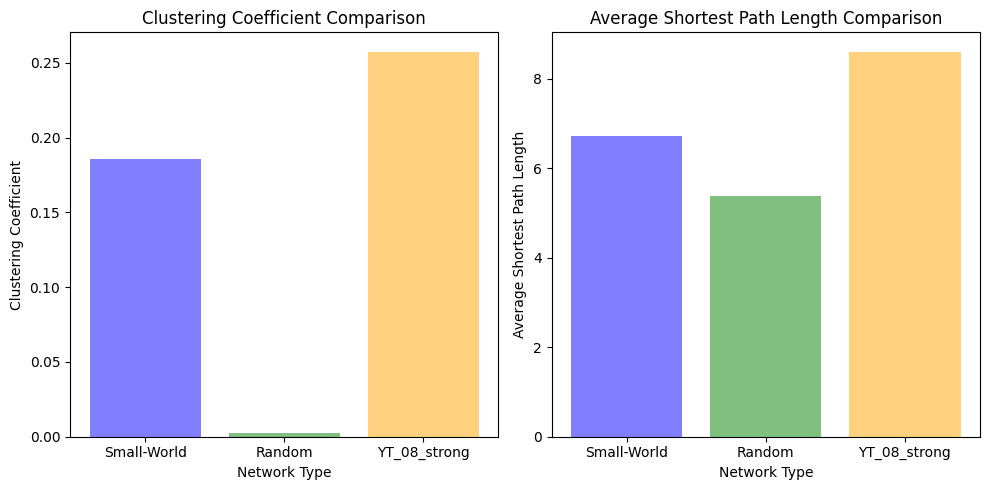

In [53]:
# Generate a Watts-Strogatz graph (small-world network)
n = 1635  # Number of nodes
k = 4    # Each node is connected to k nearest neighbors
p = 0.3  # Probability of rewiring edges
seed = 42  # Random seed for reproducibility

ws_graph = nx.watts_strogatz_graph(n, k, p, seed=seed)

# Generate a random graph with the same number of nodes and edges
random_graph = nx.gnm_random_graph(n, ws_graph.number_of_edges(), seed=seed)

# Generate a regular graph with the same number of nodes and edges
#regular_graph = nx.random_regular_graph(k, n, seed=seed)

# Calculate clustering coefficient and average shortest path length
ws_cc = nx.average_clustering(ws_graph)
ws_aspl = nx.average_shortest_path_length(ws_graph)

random_cc = nx.average_clustering(random_graph)
random_aspl = ASP(random_graph)#nx.average_shortest_path_length(random_graph)

regular_cc = nx.average_clustering(giant_subgraph8) # earlier input was `regular_graph`
g11 = giant_subgraph8.to_undirected()
regular_aspl = ASP(g11) # earlier input was `regular_graph`

# Print the results
print("Watts-Strogatz (Small-World) Network:")
print("Clustering Coefficient:", ws_cc)
print("Average Shortest Path Length:", ws_aspl)
print("\nRandom Network:")
print("Clustering Coefficient:", random_cc)
print("Average Shortest Path Length:", random_aspl)
print("\nRegular Network:")
print("Clustering Coefficient:", regular_cc)
print("Average Shortest Path Length:", regular_aspl)

# Plot the results
labels = ['Small-World', 'Random', 'YT_08_strong']
cc_values = [ws_cc, random_cc, regular_cc]
aspl_values = [ws_aspl, random_aspl, regular_aspl]

plt.figure(figsize=(10, 5))
colors = ['blue', 'green', 'orange']
alphas = [0.5, 0.5,0.5]
plt.subplot(1, 2, 1)
plt.bar(labels, cc_values,color=colors,alpha=0.5)
plt.xlabel('Network Type')
plt.ylabel('Clustering Coefficient')
plt.title('Clustering Coefficient Comparison')

plt.subplot(1, 2, 2)
plt.bar(labels, aspl_values,color=colors,alpha=0.5)
plt.xlabel('Network Type')
plt.ylabel('Average Shortest Path Length')
plt.title('Average Shortest Path Length Comparison')

plt.tight_layout()
plt.show()

In [95]:
# sigma = C/Cr / L/Lr
sig_v = (regular_cc/random_cc)/(regular_aspl/random_aspl)
sig_v

63.58253193468334

### <span style="color:teal">HITS calculation for the network</span>

In [96]:
def HITS_df(g):
    h, a = nx.hits(g)
    #print(len(h))
    #print(type(h))

    # creating hub value list
    key = []
    hub_value = []
    for k,v in h.items():
        key.append(k)
        hub_value.append(v)

    # creating authority value list
    nodes = []
    authority = []
    for k,v in a.items():
        nodes.append(k)
        authority.append(v)

    hub_df = pd.DataFrame({'node ID':key,'hub_value':hub_value})
    auth_df = pd.DataFrame({'node ID':nodes,'authority_value':authority})

    HITS_df = pd.merge(hub_df,auth_df,on='node ID')
    return HITS_df

In [98]:
hits_df07 = HITS_df(g1)
hits_df08 = HITS_df(g2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


In [116]:
hits_df07

,node ID,hub_value,authority_value
0,GEn9QkLAbC8,0.000000e+00,0.000000e+00
1,ooQ2rVCsecA,0.000000e+00,9.462419e-19
2,5k9zhok_iqo,0.000000e+00,8.537536e-19
3,Rtr_GCfFzBI,0.000000e+00,6.812905e-19
4,jxvetM7uqms,0.000000e+00,-1.985478e-18
...,...,...,...
108238,oOjkCOUVeTg,-2.219816e-19,-1.181927e-17
108239,1sGQRy65ItE,0.000000e+00,-7.057588e-18
108240,Di1k5AIdVS0,-3.676751e-20,2.467281e-18
108241,5gh4Bh_wx8c,7.473801e-20,-5.571410e-18


In [113]:
# eigenvector centrality
result_dict = nx.eigenvector_centrality(g1)
# eccentricity values
result_dict2 = calculate_eccentricity(g1)

In [107]:
nodes = []
eigne_node = []
for k,v in result_dict.items():
        nodes.append(k)
        eigne_node.append(v)
        
eigen_df = pd.DataFrame({'node ID':nodes,'eigen_centrality':eigne_node})
eigen_df

,node ID,eigen_centrality
0,GEn9QkLAbC8,1.133932e-17
1,ooQ2rVCsecA,5.284022e-08
2,5k9zhok_iqo,3.212421e-32
3,Rtr_GCfFzBI,6.346490e-32
4,jxvetM7uqms,3.212421e-32
...,...,...
108238,oOjkCOUVeTg,3.212421e-32
108239,1sGQRy65ItE,3.212421e-32
108240,Di1k5AIdVS0,7.835173e-34
108241,5gh4Bh_wx8c,7.835173e-34


In [115]:
nodes2 = []
eccentric_node = []
for k,v in result_dict2.items():
        nodes2.append(k)
        eccentric_node.append(v)
        
eccentric_df = pd.DataFrame({'node ID':nodes2,'eccentricity':eccentric_node})
eccentric_df

,node ID,eccentricity
0,GEn9QkLAbC8,0
1,ooQ2rVCsecA,0
2,5k9zhok_iqo,0
3,Rtr_GCfFzBI,0
4,jxvetM7uqms,0
...,...,...
108238,oOjkCOUVeTg,0
108239,xJyulkLamCI,0
108240,Di1k5AIdVS0,0
108241,5gh4Bh_wx8c,0


In [121]:
#final combined df
result_DF = pd.merge(eigen_df, eccentric_df, on='node ID')
result_DF = pd.merge(result_DF,hits_df07, on='node ID')
result_DF

,node ID,eigen_centrality,eccentricity,hub_value,authority_value
0,GEn9QkLAbC8,1.133932e-17,0,0.000000e+00,0.000000e+00
1,ooQ2rVCsecA,5.284022e-08,0,0.000000e+00,9.462419e-19
2,5k9zhok_iqo,3.212421e-32,0,0.000000e+00,8.537536e-19
3,Rtr_GCfFzBI,6.346490e-32,0,0.000000e+00,6.812905e-19
4,jxvetM7uqms,3.212421e-32,0,0.000000e+00,-1.985478e-18
...,...,...,...,...,...
108238,oOjkCOUVeTg,3.212421e-32,0,-2.219816e-19,-1.181927e-17
108239,1sGQRy65ItE,3.212421e-32,0,0.000000e+00,-7.057588e-18
108240,Di1k5AIdVS0,7.835173e-34,0,-3.676751e-20,2.467281e-18
108241,5gh4Bh_wx8c,7.835173e-34,0,7.473801e-20,-5.571410e-18


In [126]:
result_DF.describe()

,eigen_centrality,eccentricity,hub_value,authority_value
count,1.082430e+05,108243.000000,1.082430e+05,1.082430e+05
mean,3.753331e-04,0.463263,9.238473e-06,9.238473e-06
std,3.016236e-03,1.318732,4.174052e-04,1.519722e-03
min,7.835173e-34,0.000000,-9.574833e-17,-1.524492e-15
25%,7.835173e-34,0.000000,-4.588225e-20,-3.732446e-18
50%,6.432677e-31,0.000000,0.000000e+00,6.166166e-21
75%,1.562842e-16,0.000000,4.143911e-20,3.716526e-18
max,6.354022e-02,20.000000,1.886792e-02,2.500000e-01


In [128]:
result_DF = result_DF.sort_values(by='eigen_centrality', ascending=False)
result_DF.head()

,node ID,eigen_centrality,eccentricity,hub_value,authority_value
95465,qANpWiRLzp4,0.06354,2,-6.493497e-18,-7.894297e-17
43318,Vqni335i-88,0.06354,2,-6.085658e-18,-8.258719e-17
43316,MbBNX3OguXk,0.06354,2,-6.476415e-18,-7.984836e-17
43317,H8TB9OrfwZU,0.06354,2,-6.467363e-18,-8.032807e-17
43315,tW6TB41Tj3c,0.06354,2,-6.170857e-18,-7.807161e-17


In [131]:
result_DF = result_DF.sort_values(by='eccentricity', ascending=False)
result_DF.head(10)

,node ID,eigen_centrality,eccentricity,hub_value,authority_value
43568,vvOgHmcdQho,2.042722e-12,20,7.356582e-20,2.098904e-18
96934,3Q7Fy_gi9FM,7.860637e-13,19,-1.400046e-21,-5.644810e-18
43567,tlvtc1AbHsY,1.384636e-12,19,-9.670967e-20,7.295893e-18
52084,3K_3YP8bhas,5.832610e-11,19,-2.034846e-19,5.453239e-19
73132,lzFuB781vtg,1.133496e-08,19,-1.941448e-19,-1.172612e-17
96947,QRMxpJtdOwU,8.964427e-11,19,-9.365498e-20,-1.140833e-17
97018,SKi3NK8qrvk,2.967162e-11,18,8.780292e-19,-1.058745e-18
38751,N7Uj3puA_1c,1.363065e-10,18,-3.337116e-17,-1.703494e-17
73049,T6WdTfV8GhU,1.378561e-06,18,2.060479e-18,-3.302094e-18
38813,yYJdTce102U,4.033838e-11,18,-3.453601e-17,-2.142946e-18


In [146]:
result_DF = result_DF.sort_values(by='hub_value', ascending=False)
filtered_resdf = result_DF[(result_DF['eccentricity'] >0.9) & (result_DF['eccentricity'] <21)]
filtered_resdf.head()

,node ID,eigen_centrality,eccentricity,hub_value,authority_value
44004,p4VAGo7QfC8,0.000114,1,7.145688e-17,9.076996e-16
44006,kka3t__RsCo,0.000114,1,7.121321e-17,9.206138e-16
44005,a3CeuLRB9FQ,0.000114,1,7.072588e-17,9.464423e-16
44008,zrkaVueViTE,0.000114,1,7.048222e-17,9.593565e-16
44007,hEqqcUXb7aI,0.000114,1,7.045495e-17,9.608018e-16


### <span style="color:teal">SimRank Similarity calculation for the network</span>

In [ ]:
def simrank_similarity(graph, C=0.8, max_iterations=10):
    # Get a sorted list of nodes in the graph
    nodes = sorted(graph.nodes())

    # Initialize similarity matrix with zeros
    num_nodes = len(nodes)
    similarity_matrix = np.zeros((num_nodes, num_nodes))

    # Set initial similarity values
    np.fill_diagonal(similarity_matrix, 1.0)

    # SimRank algorithm
    for iteration in range(max_iterations):
        new_similarity_matrix = np.zeros((num_nodes, num_nodes))

        for u_idx, u in enumerate(nodes):
            for v_idx, v in enumerate(nodes):
                if u != v:
                    u_neighbors = set(graph.neighbors(u))
                    v_neighbors = set(graph.neighbors(v))
                    common_neighbors = u_neighbors.intersection(v_neighbors)

                    if len(common_neighbors) > 0:
                        s_uv = sum(similarity_matrix[nodes.index(u_nb)][nodes.index(v_nb)] for u_nb in common_neighbors for v_nb in common_neighbors)
                        new_similarity_matrix[u_idx][v_idx] = C * (s_uv / (len(u_neighbors) * len(v_neighbors)))

        # Update similarity matrix
        similarity_matrix = new_similarity_matrix

    # Create DataFrame with similarity matrix and node IDs as labels
    df_similarity = pd.DataFrame(similarity_matrix, index=nodes, columns=nodes)
    return df_similarity

### <span style="color:teal">Analysing the Ego network of nodes at different depths and its relation to link making prefferences</span>

In [64]:
def get_ego_network(graph, node, depth):
    """
    Get the ego network of a node from a directed graph with a specified depth.

    Parameters:
        graph (networkx.DiGraph): The directed graph.
        node: The target node to compute the ego network.
        depth (int): The depth or radius of the ego network.

    Returns:
        networkx.DiGraph: The ego network as a directed graph.
    """
    ego_network = nx.ego_graph(graph, node, radius=depth, center=True, undirected=True)  # undirected parameters allow us control wether to control the incoming and outgoing nodes or not
    return ego_network

In [93]:
# finding nodes present in both the networks
c_set = find_common_nodes(g1,g2)
len(c_set)

1205

In [94]:
for i in range(7):
    print(c_set.pop())

nlLwhmyZbJk
4poJJu-ZH-0
-Y2rl_2ZXcA
1PFrK7Y4VlI
QM96bQkJ-mc
02XQSGk59VE
5AClcybq5e0


Now we create the ego network of a node which is present in both the networks and compare its evolution

In [148]:
ego_depthC1_1 = get_ego_network(g1,'kka3t__RsCo',1)  # another node which we used to see the ego net is `sbbKACWzvG0`
#ego_depthC2_1 = get_ego_network(g2,'kka3t__RsCo',1)

ego_depthC1_2 = get_ego_network(g1,'kka3t__RsCo',2)
#ego_depthC2_2 = get_ego_network(g2,'kka3t__RsCo',2)

ego_depthC1_3 = get_ego_network(g1,'kka3t__RsCo',3)
#ego_depthC2_3 = get_ego_network(g2,'kka3t__RsCo',3)

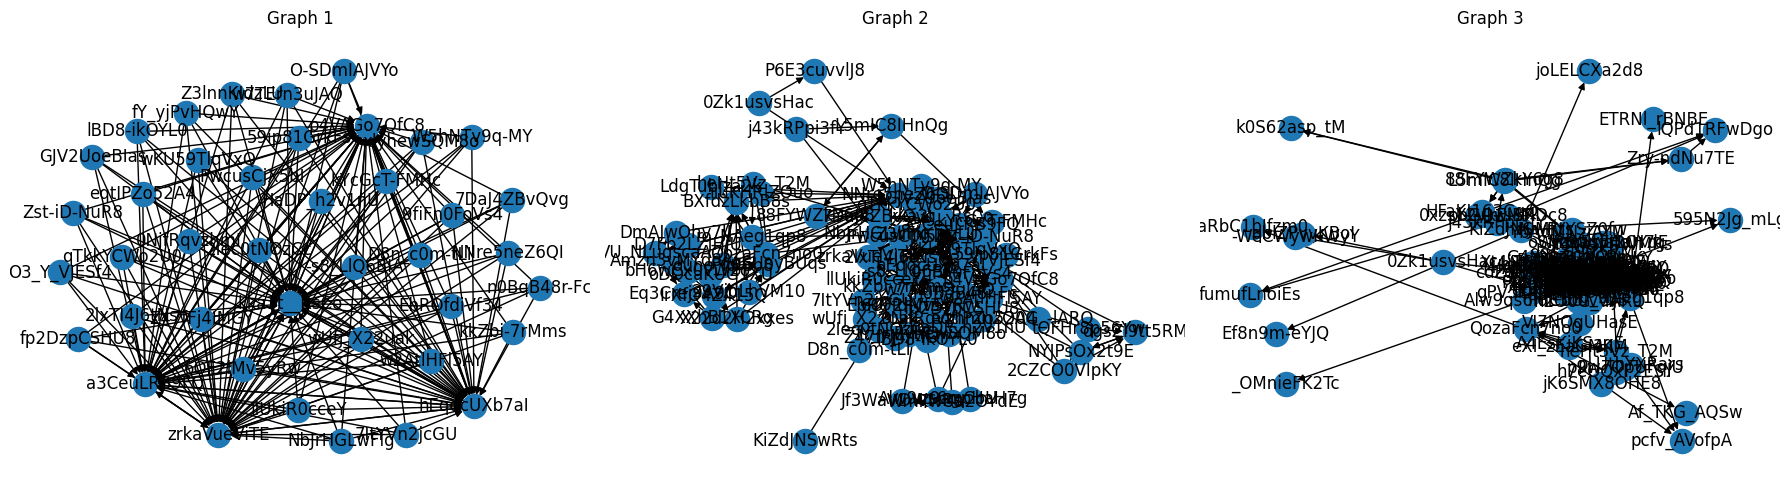

In [149]:
# Create the main figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot the first network graph in the first subplot
nx.draw(ego_depthC1_1, ax=axes[0], with_labels=True)
axes[0].set_title('Graph 1')

# Plot the second network graph in the second subplot
nx.draw(ego_depthC1_2, ax=axes[1], with_labels=True)
axes[1].set_title('Graph 2')

# Plot the third network graph in the third subplot
nx.draw(ego_depthC1_3, ax=axes[2], with_labels=True)
axes[2].set_title('Graph 3')

# Adjust spacing between subplots
plt.tight_layout()

# Show the main plot
plt.show()

In [79]:
def df_for_egoNet(subgraph):
    # Create a dictionary to store node attributes
    node_attributes = {}

    # Iterate over the nodes and their attributes in the ego network
    for node, attrs in subgraph.nodes(data=True):
        node_attributes[node] = attrs

    # Create a DataFrame from the node attributes dictionary
    node_data = pd.DataFrame.from_dict(node_attributes, orient='index')

    # Reset the index and rename columns
    node_data.reset_index(inplace=True)
    node_data.columns = ['Node'] + list(node_data.columns[1:])
    
    return node_data

In [150]:
#df for ego network at depth1 for both years
egoNet_depth1_7 = df_for_egoNet(ego_depthC1_1)
#egoNet_depth1_8 = df_for_egoNet(ego_depthC2_1)

#df for ego network at depth2 for both years
egoNet_depth2_7 = df_for_egoNet(ego_depthC1_2)
#egoNet_depth2_8 = df_for_egoNet(ego_depthC2_2)

#df for ego network at depth2 for both years
egoNet_depth3_7 = df_for_egoNet(ego_depthC1_3)
#egoNet_depth3_8 = df_for_egoNet(ego_depthC2_3)

In [151]:
# Print the node information DataFrame
egoNet_depth1 = df_for_egoNet(ego_depthC1_1)
egoNet_depth2 = df_for_egoNet(ego_depthC1_2)
egoNet_depth3 = df_for_egoNet(ego_depthC1_3)

egoNet_depth1

,Node,uploader,age,category,length,views,rate,ratings,comments
0,a3CeuLRB9FQ,sonybmg,775.0,Music,210.0,1792.0,5.00,10.0,6.0
1,6OF2lMv5yRw,sonybmg,738.0,Music,261.0,1357.0,5.00,6.0,3.0
2,eqtIPZo52A4,sonybmg,775.0,Music,249.0,337.0,5.00,3.0,7.0
3,hEqqcUXb7aI,sonybmg,775.0,Music,237.0,2318.0,4.94,17.0,5.0
4,llUkiR0cceY,sonybmg,775.0,Music,248.0,2009.0,4.79,14.0,2.0
5,kkZbi-7rMms,sonybmg,775.0,Music,325.0,2089.0,5.00,14.0,4.0
6,Zst-iD-NuR8,sonybmg,775.0,Music,284.0,1229.0,5.00,6.0,1.0
7,HaDP_h2v1nU,sonybmg,775.0,Music,265.0,497.0,4.33,6.0,0.0
8,D8n_c0m-tLI,sonybmg,734.0,Music,193.0,585.0,5.00,5.0,1.0
9,W5hNTv9q-MY,sonybmg,738.0,Music,252.0,2721.0,4.57,14.0,5.0


In [152]:
egoNet_depth1.describe()

,age,length,views,rate,ratings,comments
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,755.756098,239.317073,3790.390244,4.695366,15.658537,6.341463
std,19.933365,33.823394,10662.555374,0.828076,33.249519,16.029051
min,731.000000,193.000000,116.000000,0.000000,0.000000,0.000000
25%,737.000000,210.000000,413.000000,4.780000,4.000000,1.000000
50%,773.000000,237.000000,943.000000,5.000000,6.000000,2.000000
75%,775.000000,258.000000,2089.000000,5.000000,11.000000,4.000000
max,775.000000,341.000000,58216.000000,5.000000,161.000000,84.000000


In [88]:
egoNet_depth2

,Node,uploader,age,category,length,views,rate,ratings,comments
0,__86eNI1g7w,beverlyhills90210fan,483.0,Entertainment,40.0,7372.0,5.00,9.0,7.0
1,u4zvq0nBBWE,beverlyhills90210fan,483.0,Entertainment,25.0,7846.0,4.80,10.0,4.0
2,RI7w3nF2eis,live8706,752.0,Entertainment,242.0,3154.0,3.75,8.0,3.0
3,ZFZozv5tzqE,beverlyhills90210fan,484.0,Entertainment,16.0,2966.0,5.00,7.0,0.0
4,dk24WnGU7kg,beverlyhills90210fan,515.0,Entertainment,218.0,7514.0,4.70,20.0,5.0
5,V-i4gn5ozK8,beverlyhills90210fan,483.0,Entertainment,32.0,7959.0,5.00,9.0,12.0
6,dbKT7y5zLtU,beverlyhills90210fan,484.0,Entertainment,27.0,10974.0,4.90,20.0,14.0
7,rGk9E4oKYYI,beverlyhills90210fan,483.0,Entertainment,24.0,10453.0,4.83,12.0,10.0


In [90]:
egoNet_depth2.describe()

,age,length,views,rate,ratings,comments
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,520.875000,78.000000,7279.750000,4.747500,11.875000,6.875000
std,94.044727,94.283766,2932.396716,0.417706,5.221863,4.793969
min,483.000000,16.000000,2966.000000,3.750000,7.000000,0.000000
25%,483.000000,24.750000,6317.500000,4.775000,8.750000,3.750000
50%,483.500000,29.500000,7680.000000,4.865000,9.500000,6.000000
75%,491.750000,84.500000,8582.500000,5.000000,14.000000,10.500000
max,752.000000,242.000000,10974.000000,5.000000,20.000000,14.000000


In [ ]:
egoNet_depth3

,Node,uploader,age,category,length,views,rate,ratings,comments
0,__86eNI1g7w,beverlyhills90210fan,483.0,Entertainment,40.0,7372.0,5.00,9.0,7.0
1,u4zvq0nBBWE,beverlyhills90210fan,483.0,Entertainment,25.0,7846.0,4.80,10.0,4.0
2,RI7w3nF2eis,live8706,752.0,Entertainment,242.0,3154.0,3.75,8.0,3.0
3,4qCvp5a2tp4,beverlyhills90210fan,514.0,Entertainment,180.0,13626.0,4.82,44.0,23.0
4,ZFZozv5tzqE,beverlyhills90210fan,484.0,Entertainment,16.0,2966.0,5.00,7.0,0.0
5,dk24WnGU7kg,beverlyhills90210fan,515.0,Entertainment,218.0,7514.0,4.70,20.0,5.0
6,V-i4gn5ozK8,beverlyhills90210fan,483.0,Entertainment,32.0,7959.0,5.00,9.0,12.0
7,dbKT7y5zLtU,beverlyhills90210fan,484.0,Entertainment,27.0,10974.0,4.90,20.0,14.0
8,rGk9E4oKYYI,beverlyhills90210fan,483.0,Entertainment,24.0,10453.0,4.83,12.0,10.0


In [91]:
egoNet_depth3.describe()

,age,length,views,rate,ratings,comments
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,520.111111,89.333333,7984.888889,4.755556,15.444444,8.666667
std,88.000631,94.521162,3463.967286,0.391475,11.769782,7.000000
min,483.000000,16.000000,2966.000000,3.750000,7.000000,0.000000
25%,483.000000,25.000000,7372.000000,4.800000,9.000000,4.000000
50%,484.000000,32.000000,7846.000000,4.830000,10.000000,7.000000
75%,514.000000,180.000000,10453.000000,5.000000,20.000000,12.000000
max,752.000000,242.000000,13626.000000,5.000000,44.000000,23.000000


>From the output above, in the standard deviation row for the `age` attribute, we see the lowest deviation, we are choosing to ignore the STD value of rate cause it has a very small range(1-5). 

### <span style="color:teal">Analysing the clustering in the weakly connected component</span>

In [54]:
def clustering_df_maker(G):
  values = []
  sizes = []
  clusts = []
  effi_values = []
  components = nx.weakly_connected_components(G)

  for component in tqdm(components):
      component_graph = G.subgraph(component)
      # calculating its trasitivity per component
      tra_value= nx.transitivity(component_graph)
      values.append(tra_value)

      # calculating its size
      component_size = len(component)
      sizes.append(component_size)

      # calculating its average clustering
      clust = nx.average_clustering(component_graph)
      clusts.append(clust)

      # calculating the local efficieny of the components
      component_graphU = component_graph.to_undirected()
      effi = nx.local_efficiency(component_graphU)
      effi_values.append(effi)
  transitivity_df = pd.DataFrame({'Component Size':sizes,'transitivity':values,'average clustering':clusts,'local efficiency':effi_values})
  return transitivity_df

In [57]:
clust_DF = clustering_df_maker(g1)
clust_DF = clust_DF.sort_values(by='Component Size', ascending=False)

clust_DF2 = clustering_df_maker(g2)
clust_DF2 = clust_DF2.sort_values(by='Component Size', ascending=False)

13786it [00:12, 1095.22it/s]
10175it [00:16, 635.46it/s] 


In [58]:
# Filter the DataFrame for values within a range to exclue 0s
filtered_CLUSTdf = clust_DF[(clust_DF['transitivity'] >0.05) & (clust_DF['transitivity'] <0.99)]

filtered_CLUSTdf2 = clust_DF2[(clust_DF2['transitivity'] >0.05) & (clust_DF2['transitivity'] <0.99)]
filtered_CLUSTdf2

,Component Size,transitivity,average clustering,local efficiency
0,86773,0.251185,0.157354,0.250712
115,456,0.294812,0.252464,0.392434
1399,374,0.402542,0.305840,0.489655
46,225,0.242297,0.189231,0.308050
524,211,0.244645,0.186646,0.330547
...,...,...,...,...
3336,3,0.500000,0.500000,1.000000
3345,3,0.500000,0.666667,1.000000
3357,3,0.500000,0.666667,1.000000
2390,3,0.500000,0.666667,1.000000


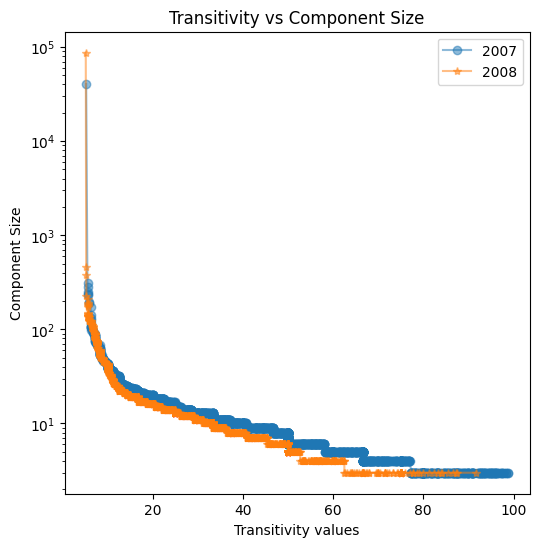

In [61]:
#scalling the values for better visualisation
listed = list(filtered_CLUSTdf['transitivity'])
listed.sort()

listed2 = list(filtered_CLUSTdf2['transitivity'])
listed2.sort()

i=0
for i in range(len(listed)):
    listed[i] = listed[i]*100
    
i=0    
for i in range(len(listed2)):
    listed2[i] = listed2[i]*100

# Plotting the chart
plt.figure(figsize=(6, 6))
plt.plot(listed,list(filtered_CLUSTdf['Component Size']), 'o-',alpha=0.5, label='2007')
plt.plot(listed2,list(filtered_CLUSTdf2['Component Size']), '*-',alpha=0.5, label='2008')


# Set plot labels and title
plt.xlabel('Transitivity values')
plt.ylabel('Component Size')
plt.title('Transitivity vs Component Size')

# Adjust axis scales
plt.yscale('log')  # Set x-axis scale to logarithmic
plt.legend()
# Show the plot
plt.show()

## Exporting the graphs

After doing the statistical measures, we also export the graphs and sub-graphs made into a file format supported by the network analysis and visualisation software `GEPHI` were we did final network visualisation to support the measures with a visual observations

In [ ]:
#export(g1,'g1.gexf.gz')

In [ ]:
#export(g2,'g2.gexf.gz')

In [ ]:
#export(giant_subgraph,'weakly_connected.gexf.gz')

In [ ]:
#export(giant_subgraph8,'strongly_connected.gexf.gz')